In [123]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

# Parameters for user to set
testing_batch_size = 64
training_batch_size = 64
num_validation_samples = 64
epochs = 2
plot_rows = 4 # num of test image rows to run and plot
plot_cols = 6 # ditto (cols must be even)
add_skip_connect = False # if true will learn ID function in like 2 epochs




# Getting the MNIST data set and logging its parameters
data = input_data.read_data_sets('data/MNIST', one_hot=True)
img_size = 28
img_size_flat = img_size*img_size
img_shape = (img_size, img_size)
num_channels_x = 1
training_size = len(data.train.labels)


# Graph Helper Functions
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape))

def new_biases(length):
    return tf.Variable(tf.truncated_normal(shape=[length]))


def new_conv_layer(input,num_input_channels,filter_size,num_filters, use_pooling=True):
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input=input,filter=weights, strides=[1,1,1,1], padding='SAME')
    layer += biases
    if(use_pooling):
        layer = tf.nn.max_pool(value=layer, ksize=[1,2,2,1], strides= [1,2,2,1], padding='SAME')
    layer = tf.nn.relu(layer)
    return layer, weights
    

def new_conv_trans_layer(inputs,num_input_channels,filter_size,num_filters):
    layer = tf.layers.conv2d_transpose(inputs=inputs,filters=num_filters, kernel_size=[2,2], strides=2)
    return layer


# This functions builds the graph for the autoencoder
def build_net(x, add_skip_connect):
    filter_size = 3
    num_filters_l1 = 32
    num_filters_l2 = 8
    num_filters_l3 = 32
    num_filters_output = 1

    # Down Sampling
    conv_layer_1,_ = new_conv_layer(x ,num_channels_x,filter_size,num_filters_l1, use_pooling=True)
    conv_layer_2,_ = new_conv_layer(conv_layer_1, num_filters_l1, filter_size, num_filters_l2, use_pooling=True)    
    
    # Up Sampling
    conv_layer_3 = new_conv_trans_layer(conv_layer_2 ,num_filters_l2,filter_size,num_filters_l3)
    # Add conv_layer_1 and conv_layer_3 together (both are (14,14) images)
    if(add_skip_connect):
        print('conv_layer_3 in skip connected. Shape should be: [%s + %s]'%(conv_layer_3.get_shape(), conv_layer_1.get_shape()))
        conv_layer_3 = tf.concat([conv_layer_3,conv_layer_1],3) # index 3 is the channel index
        num_filters_l3 = conv_layer_3.get_shape()[3]
    
    output = new_conv_trans_layer(conv_layer_3, num_filters_l3, filter_size, num_filters_output)
    output = tf.nn.relu(output, name='output')
    
    # save an optimizer for the given graph above
    cost = tf.reduce_mean(tf.square(output-x))
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    print('conv_layer_1: %s'%conv_layer_1.get_shape())
    print('conv_layer_2: %s'%conv_layer_2.get_shape())
    print('conv_layer_3: %s'%conv_layer_3.get_shape())
    print('conv_layer_4: %s'%output.get_shape())

    return cost, optimizer, output




## Build the autoencoder graph and set up TF variables
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 1], name= 'x')
cost, optimizer, output = build_net(x, add_skip_connect=add_skip_connect)
session = tf.Session()
session.run(tf.global_variables_initializer())
saver = tf.train.Saver()

# Create vectors to save the loss function over time
epoch_training_loss_log = np.zeros(epochs)
epoch_validation_loss_log = np.zeros(epochs)

# Sample the validation set and keep it for all training
batch_x_flat_validation,_  = data.test.next_batch(num_validation_samples)
batch_x_validation  = batch_x_flat_validation.reshape((-1,img_size,img_size,1))


# Training Routine
for epoch in range(epochs):
    print('epoch: %d'%(epoch+1))
    epoch_training_loss = 0
    epoch_validation_loss = 0
    num_batches = int(training_size/training_batch_size)
    
    # iterate over all batches in training data set
    for batch in range(num_batches):
        if(batch%100==0): print('\t batch: %d'%batch)
        
        #sample a training batch
        batch_x_flat_training,_ = data.train.next_batch(training_batch_size)
        batch_x_training = batch_x_flat_training.reshape((-1,img_size,img_size,1))
        
        #run and optimize graph on given batch and log the cost
        _, c_training = session.run([optimizer, cost], feed_dict = {x: batch_x_training})
        _, c_validation =  session.run([optimizer, cost], feed_dict = {x: batch_x_validation})
        epoch_training_loss += c_training
        epoch_validation_loss += c_validation
    
    epoch_training_loss_log[epoch] = epoch_training_loss
    epoch_validation_loss_log[epoch] = epoch_validation_loss
    print('Epoch',epoch+1, 'completed out of ', epochs, 'loss: ', epoch_training_loss)



saver.save(session, './AE_model/AE_model')


Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
conv_layer_1: (?, 14, 14, 32)
conv_layer_2: (?, 7, 7, 8)
conv_layer_3: (?, 14, 14, 32)
conv_layer_4: (?, 28, 28, 1)
epoch: 1
	 batch: 0
	 batch: 100
	 batch: 200
	 batch: 300
	 batch: 400
	 batch: 500
	 batch: 600
	 batch: 700
	 batch: 800
Epoch 1 completed out of  1 loss:  106.45726659148932


'./AE_model/AE_model'

In [124]:
# Run the learned network on testing data
flat_imgs,_ = data.test.next_batch(testing_batch_size)
imgs = flat_imgs.reshape((-1,img_size,img_size,1))
feed_dict = {x: imgs}
[imgs_recon] = session.run([output], feed_dict)


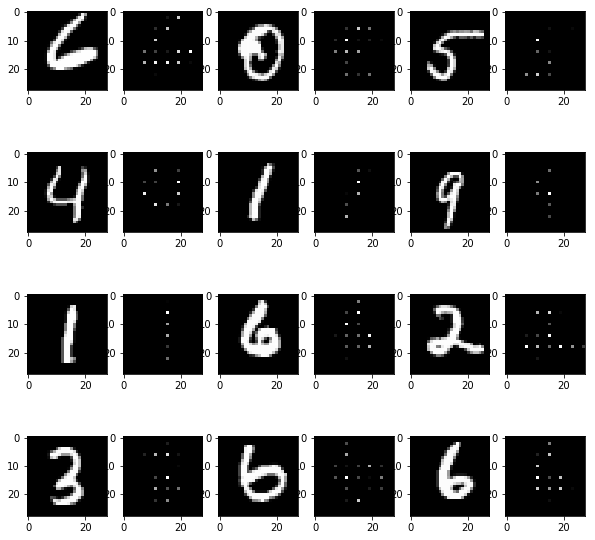

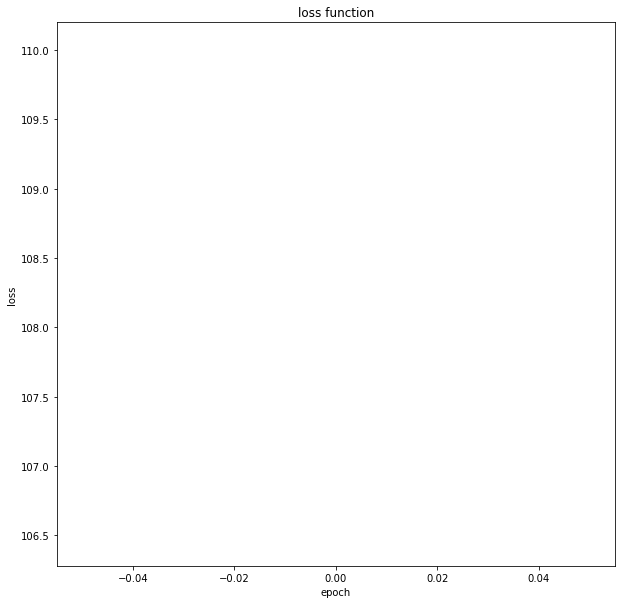

In [125]:
# Show original images and reconstructed images
fig = plt.figure(figsize=(10,10))
for i in range(1,plot_rows*plot_cols+1):
    if(i%2==1):
        fig.add_subplot(plot_rows,plot_cols,i)
        plt.imshow(imgs[i-1,:,:,0],cmap='gray')
    else:
        fig.add_subplot(plot_rows,plot_cols,i)
        plt.imshow(imgs_recon[i-2,:,:,0], cmap='gray')

plt.savefig('sample_encodings.png')
# Show loss functions
fig_2 = plt.figure(figsize=(10,10))
fig_2.add_subplot(1,1,1)
plt.plot(epoch_training_loss_log,'r',label='training loss')
plt.plot(epoch_validation_loss_log,'b', label='validation loss')
plt.title('loss function')
plt.xlabel('epoch')
plt.ylabel('loss')


plt.savefig('loss_function.png')